In [167]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [168]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [169]:
# All imports
import pandas as pd
import glob
import os
import networkx as nx
import pickle
import numpy as np
from scipy import sparse
from scipy.sparse import csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

In [170]:
# read data from CSV files
edgesFile = 'Raw/edges.csv'
nodesFile = 'Raw/nodes.csv'

edgesDf = pd.read_csv(edgesFile, sep=',')
edgesDf = edgesDf[["source", "sink"]]
print('edgesDf shape', edgesDf.shape)

nodesDf = pd.read_csv(nodesFile, sep=',')
print('nodesDf shape', nodesDf.shape)

edgesDf shape (559147, 2)
nodesDf shape (7751, 18)


In [171]:
# convert pval to float and use NaN for non numeric values
nodesDf['pval'] = pd.to_numeric(nodesDf['pval'], errors='coerce')

# remove nodes with empty or non-numeric pval
# nodesPvalDf = nodesDf[nodesDf['pval'].notna()]
# print('nodesPvalDf shape', nodesPvalDf.shape)

# construct dataframe with the selected features
tmp = nodesDf[['id', 'chromosome', 'jaccard_similarity', 'pval']]
tmp = tmp[tmp['chromosome'].notna()]
all_data = tmp[tmp['jaccard_similarity'].notna()]
print('all_data shape', all_data.shape)

all_data shape (5253, 4)


In [172]:
print('All data shape', all_data.shape)

# seperate data according to non-empty and empty pval
data_pval = all_data[all_data['pval'].notna()]
print('non-empty pval:', data_pval.shape)

data_emptyPval = all_data[all_data['pval'].isnull()]
print('empty pval:', data_emptyPval.shape)

All data shape (5253, 4)
non-empty pval: (1214, 4)
empty pval: (4039, 4)


In [173]:
# remove the outliers
data_pval = data_pval[data_pval['pval'] >= 1e-10]

data_pval.loc[data_pval['chromosome'] == 'X', 'chromosome'] = '23'
data_pval.loc[data_pval['chromosome'] == 'Y', 'chromosome'] = '24'

# convert pval to float and use NaN for non numeric values
data_pval['chromosome'] = pd.to_numeric(data_pval['chromosome'], errors='coerce')
# remove nodes with empty or non-numeric pval
data_pval = data_pval[data_pval['chromosome'].notna()]


print(data_pval.shape)

(766, 4)


In [174]:
# sort by node_id
data_pval = data_pval.sort_values(by=['id'])

nodeList = data_pval["id"].values.tolist()
print('nodeList len', len(nodeList))

nodeList len 766


In [175]:
# filter edges that are not in selected nodes
edgesDfFiltered = edgesDf[edgesDf['source'].isin(nodeList)]
edgesDfFiltered = edgesDfFiltered[edgesDfFiltered['sink'].isin(nodeList)]
print('edgesDfFiltered shape', edgesDfFiltered.shape)

edgesDfFiltered shape (2473, 2)


In [176]:
# build adj matrix
numNodes = len(nodeList)
adj = np.zeros((numNodes, numNodes))

for index, row in edgesDfFiltered.iterrows():
    u = nodeList.index(row['source'])
    v = nodeList.index(row['sink'])
    adj[u][v] = 1
    adj[v][u] = 1

adj = sparse.csr_matrix(adj)
print('adj shape', adj.shape)

adj shape (766, 766)


In [177]:
data_pval

,id,chromosome,jaccard_similarity,pval
4,4,16.0,0.002947,4.000000e-08
7,7,15.0,0.012022,1.000000e-09
66,66,1.0,0.002709,9.000000e-06
71,71,7.0,0.002951,4.000000e-06
83,83,10.0,0.012946,5.000000e-09
...,...,...,...,...
7707,7707,7.0,0.000737,3.000000e-08
7711,7711,7.0,0.004177,2.000000e-09
7713,7713,18.0,0.002464,3.000000e-08
7714,7714,19.0,0.001723,5.000000e-08


# Preparing input for Node2vec

In [178]:
features = data_pval



# one hot encode chromosome
oneHot = pd.get_dummies(features['chromosome'], prefix = 'chromosome')
featuresOneHot = features.join(oneHot)
featuresOneHot = featuresOneHot.drop('chromosome', axis = 1)

print('featuresOneHot shape', featuresOneHot.shape)
featuresOneHot

featuresOneHot shape (766, 26)


,id,jaccard_similarity,pval,chromosome_1.0,chromosome_2.0,chromosome_3.0,chromosome_4.0,chromosome_5.0,chromosome_6.0,chromosome_7.0,...,chromosome_14.0,chromosome_15.0,chromosome_16.0,chromosome_17.0,chromosome_18.0,chromosome_19.0,chromosome_20.0,chromosome_21.0,chromosome_22.0,chromosome_23.0
4,4,0.002947,4.000000e-08,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7,7,0.012022,1.000000e-09,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
66,66,0.002709,9.000000e-06,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71,71,0.002951,4.000000e-06,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
83,83,0.012946,5.000000e-09,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,7707,0.000737,3.000000e-08,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7711,7711,0.004177,2.000000e-09,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7713,7713,0.002464,3.000000e-08,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7714,7714,0.001723,5.000000e-08,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [179]:
# drop node_id column
featuresOneHot = featuresOneHot.drop('id', axis=1).reset_index(drop=True)
print(featuresOneHot)
featuresOneHot.to_numpy()

     jaccard_similarity          pval  chromosome_1.0  chromosome_2.0  \
0              0.002947  4.000000e-08               0               0   
1              0.012022  1.000000e-09               0               0   
2              0.002709  9.000000e-06               1               0   
3              0.002951  4.000000e-06               0               0   
4              0.012946  5.000000e-09               0               0   
..                  ...           ...             ...             ...   
761            0.000737  3.000000e-08               0               0   
762            0.004177  2.000000e-09               0               0   
763            0.002464  3.000000e-08               0               0   
764            0.001723  5.000000e-08               0               0   
765            0.000493  2.000000e-10               1               0   

     chromosome_3.0  chromosome_4.0  chromosome_5.0  chromosome_6.0  \
0                 0               0               0 

array([[2.94695481e-03, 4.00000000e-08, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.20215898e-02, 1.00000000e-09, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.70935961e-03, 9.00000000e-06, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.46366100e-03, 3.00000000e-08, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.72286488e-03, 5.00000000e-08, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.93461633e-04, 2.00000000e-10, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [180]:
# scipy.sparse.csr_matrix(adj.values)
adj = csr_matrix(adj)
features = csr_matrix(featuresOneHot)
# data_pval = csr_matrix(data_pval)
features

<766x25 sparse matrix of type '<class 'numpy.float64'>'
	with 2281 stored elements in Compressed Sparse Row format>

In [181]:
data_name = 'Alzheimer'
f1 = 'Processed/' + data_name + '_features_hop_' + str(0) + '.pickle'
a1 = 'Processed/' + data_name + '_adj_hop_' + str(0) + '.pickle'
print('Stored in ', f1, 'and ', a1, 'and second column of the matrix is the pval column')
with open(f1, 'wb') as handle: pickle.dump(features, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(a1, 'wb') as handle: pickle.dump(adj, handle, protocol=pickle.HIGHEST_PROTOCOL)

Stored in  Processed/Alzheimer_features_hop_0.pickle and  Processed/Alzheimer_adj_hop_0.pickle and second column of the matrix is the pval column


# Preparing input for Attri2vec, GraphSage and GCN

In [182]:
features = data_pval

# seperate predicting attribute from input feature
preicting_attr = features['pval']
features = features.drop('pval', axis=1)

# one hot encode chromosome
oneHot = pd.get_dummies(features['chromosome'], prefix = 'chromosome')
features = features.join(oneHot)
featuresOneHot = features.drop('chromosome', axis = 1)

print('featuresOneHot shape', featuresOneHot.shape)
featuresOneHot

featuresOneHot shape (766, 25)


,id,jaccard_similarity,chromosome_1.0,chromosome_2.0,chromosome_3.0,chromosome_4.0,chromosome_5.0,chromosome_6.0,chromosome_7.0,chromosome_8.0,...,chromosome_14.0,chromosome_15.0,chromosome_16.0,chromosome_17.0,chromosome_18.0,chromosome_19.0,chromosome_20.0,chromosome_21.0,chromosome_22.0,chromosome_23.0
4,4,0.002947,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7,7,0.012022,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
66,66,0.002709,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71,71,0.002951,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
83,83,0.012946,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,7707,0.000737,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7711,7711,0.004177,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7713,7713,0.002464,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7714,7714,0.001723,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [183]:
# drop node_id column
featuresOneHot = featuresOneHot.drop('id', axis=1).reset_index(drop=True)
# print(featuresOneHot)
featuresOneHot.to_numpy()
print(preicting_attr.shape)
preicting_attr = preicting_attr.to_numpy()
print(preicting_attr.shape)



(766,)
(766,)


In [184]:
# scipy.sparse.csr_matrix(adj.values)
adj = csr_matrix(adj)
featuresOneHot = csr_matrix(featuresOneHot)
# preicting_attr = csr_matrix(preicting_attr)
# print('preicting_attr.shape of sparse matrix', preicting_attr.shape)
# preicting_attr = preicting_attr.todense()
# print('shape of dense matrix', preicting_attr.shape)
# print(preicting_attr)


data_name = 'Alzheimer'
f1 = 'Processed/' + data_name + '_features_without_pval_hop_' + str(0) + '.pickle'
a1 = 'Processed/' + data_name + '_adj_without_pval_hop_' + str(0) + '.pickle'
p1 = 'Processed/' + data_name + '_pval_hop_' + str(0) + '.pickle'
print('Stored in ', f1, 'and ', a1, 'and', p1)
with open(f1, 'wb') as handle: pickle.dump(featuresOneHot, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(a1, 'wb') as handle: pickle.dump(adj, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(p1, 'wb') as handle: pickle.dump(preicting_attr, handle, protocol=pickle.HIGHEST_PROTOCOL)

Stored in  Processed/Alzheimer_features_without_pval_hop_0.pickle and  Processed/Alzheimer_adj_without_pval_hop_0.pickle and Processed/Alzheimer_pval_hop_0.pickle


# Corelation between pval and only features

In [185]:
features = data_pval

# seperate predicting attribute from input feature
preicting_attr = features['pval']

# one hot encode chromosome
oneHot = pd.get_dummies(features['chromosome'], prefix = 'chromosome')
features = features.join(oneHot)
featuresOneHot = features.drop('chromosome', axis = 1)

print('featuresOneHot shape', featuresOneHot.shape)
featuresOneHot

featuresOneHot shape (766, 26)


,id,jaccard_similarity,pval,chromosome_1.0,chromosome_2.0,chromosome_3.0,chromosome_4.0,chromosome_5.0,chromosome_6.0,chromosome_7.0,...,chromosome_14.0,chromosome_15.0,chromosome_16.0,chromosome_17.0,chromosome_18.0,chromosome_19.0,chromosome_20.0,chromosome_21.0,chromosome_22.0,chromosome_23.0
4,4,0.002947,4.000000e-08,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7,7,0.012022,1.000000e-09,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
66,66,0.002709,9.000000e-06,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71,71,0.002951,4.000000e-06,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
83,83,0.012946,5.000000e-09,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,7707,0.000737,3.000000e-08,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7711,7711,0.004177,2.000000e-09,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7713,7713,0.002464,3.000000e-08,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7714,7714,0.001723,5.000000e-08,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


<AxesSubplot:>

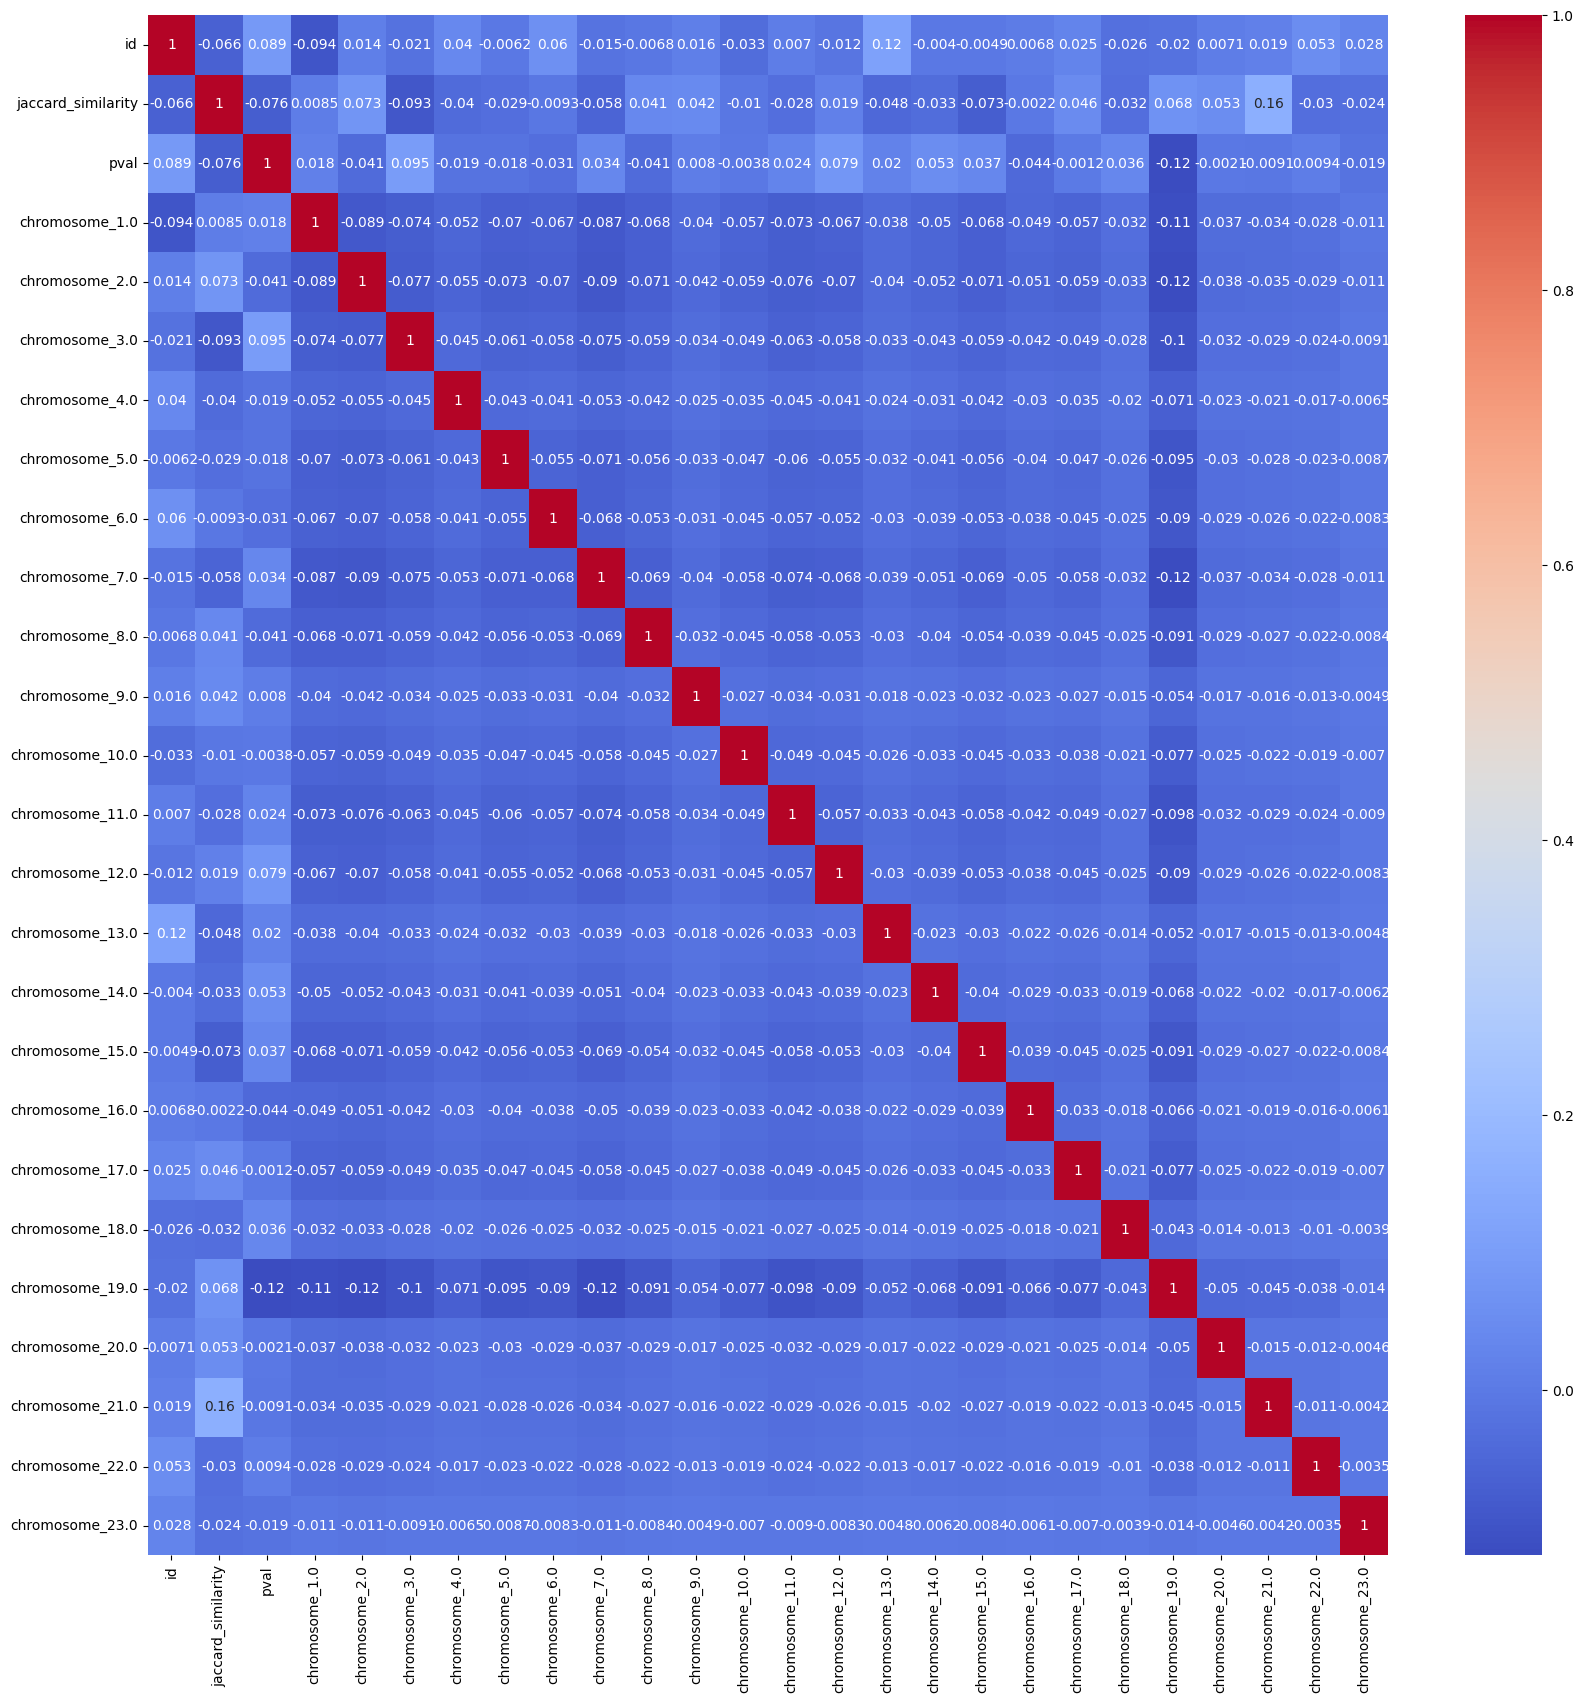

In [187]:
corr = featuresOneHot.corr()
plt.figure(figsize=(20,20))
corr_heatmap = sns.heatmap(corr, annot = True, cmap='coolwarm')

corr_heatmap

# Corelation between pval and embedding of features & adjacency (by GCN)